In [21]:
#importing all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.special import entr
from sklearn.metrics import confusion_matrix


In [22]:
#importing the original training data
df = pd.read_csv(r'S:\CS\SPRING_2022\ML_529\Project 2_NB and LR\NaiveBayes\training.csv')

In [23]:
#Splitting the data into training and testing data in the ratio 80:20
training_data, testing_data = train_test_split(df, test_size = .2, random_state = 42)

#List of all the class labels for the training data
class_labels = training_data[training_data.columns[-1]].unique()  

#total number of different words in the dataset
total_words = training_data.shape[1] - 2

#likely matrix full of zero's
likely_mtrx = np.zeros((len(class_labels), total_words))

#beta_likely matrix which is used to form log_likelihood matrix
beta_likely_mtrx =  np.zeros((len(class_labels), total_words))

In [27]:
#function for reshaping the training data
def reshape_data(training_data):
    
    #here '1' and '14' are the names of index and class columns
    new_columns = [column for column in training_data.columns if column not in ['1', '14']]
    reshaped_data = training_data[new_columns]
    
    return reshaped_data

In [28]:
#function for finding the priors
def priors(training_data, class_labels):
    #a dictionary to store priors for each class
    prior_probs = {} 
    for i in class_labels:
        #'14' is the name for class column
        each_classdata = training_data[training_data['14'] == i]
        prior_probs[i] = len(each_classdata) / float( len(training_data))
    return prior_probs
prior_probs = priors(training_data, class_labels)

In [29]:
#different beta values in the form of a list
beta_values = [.00001, .0001, .001, .01, .1, 1]

#beta = 0.01
beta = 1/total_words
alpha = 1 + beta

In [30]:
#function for finding the log likelihood matrix 
def likelihoods(training_data, beta):
    #reshaping the training data
    reshaped_data = reshape_data(training_data)
    
    #converting the values of the dataframe to np array
    reshaped_array = reshaped_data.values
    
    #considering the nonzero positions of the resultant array
    nonzero_pos = np.nonzero(reshaped_array)
        
    for pos in range(len(nonzero_pos[0])): 
        try:
            row_pos = nonzero_pos[0][pos]
            col_pos = nonzero_pos[1][pos]
            value = reshaped_array[row_pos][col_pos]
            row_cls = training_data.iloc[row_pos][-1]
            current = likely_mtrx[row_cls-1 ][col_pos]
            likely_mtrx[row_cls-1 ][col_pos] = current + value
            
        except IndexError:
            print (nonzero_pos[0][pos], nonzero_pos[1][pos], training_data.iloc[row_pos][-1])
            
    #for each possible class the total words are calculated     
    for i in range(len(class_labels)):  
        class_wc = sum(likely_mtrx[i])
        for j in range(total_words):
            beta_likely = likely_mtrx[i][j]
            beta_likely += beta 
            beta_likely /= (class_wc + (total_words * beta))
            beta_likely_mtrx[i][j] = beta_likely 
            
    log_likely_mtrx = np.log2(beta_likely_mtrx)
    
    #returns the log_likelihood matrix
    return log_likely_mtrx

In [31]:
#function to test the accuracy on validation data
def validation(testing_data, beta): 
    log_likely_mtrx = likelihoods(training_data, beta)
    
    #a variable to store the count of correct predictions
    count = 0
    
    #for each row of the validation data
    for row in range(len(testing_data)):
        actual_value = testing_data.iloc[row][-1]
        updated_list = testing_data.iloc[row][1:-1].tolist()
        c_results = []
        
        for i in range(len(class_labels)):
            dot_product = np.log2(prior_probs[i+1]) + np.dot(updated_list, log_likely_mtrx[i])
            c_results.append(dot_product)
        predicted = int(np.argmax(c_results)) + 1
        if actual_value == predicted:
            count += 1
    
    #calculates the accuracy of validationd 
    training_accuracy = float (count) / len(testing_data)
    
    #returns validation accuracy
    return training_accuracy

In [32]:
training_accuracy = validation(testing_data, beta)
print(training_accuracy)

0.8604166666666667


In [33]:
#function to test the actual testing data
def testing(actual_test_data, beta):
    log_likely_mtrx = likelihoods(training_data, beta)
    
    #a list to store the id and class of each row of testing data
    result =[]
    result.append(['id','class'])
    
    #iterates through each row
    for i in range(len(actual_test_data)):
        
        #num_r = actual_test_data.iloc[i][0]
        updated_list = actual_test_data.iloc[i][1:].tolist()
        c_results = []
        
        for j in range(len(class_labels)):
            dot_product = np.log2(prior_probs[j+1]) + np.dot(updated_list, log_likely_mtrx[j])
            c_results.append(dot_product)
        
        #predicts the class for that row
        predicted_class = int(np.argmax(c_results)) + 1
        
        #appends the id and class to the result list
        result.append([i+12001, predicted_class])
        
    #returns the main result list
    return result

In [34]:
#importing the actual testing data
actual_test_data = pd.read_csv(r'S:\CS\SPRING_2022\ML_529\Project 2_NB and LR\NaiveBayes\testing.csv',header=None)


In [35]:
final_result = testing(actual_test_data, beta)

# Saving the predicted values to a CSV file inorder to upload it to kaggle
output = pd.DataFrame(final_result)
output.to_csv("predicted.csv", header = None, index= None)

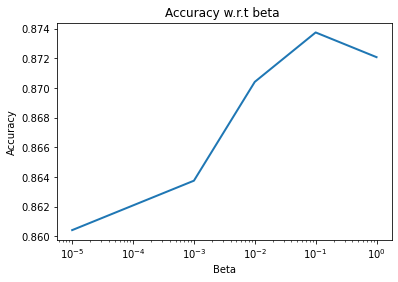

In [13]:
#a list to store the accuracies of validation data for each beta
accuracies=[]

#iterates over each beta value
for beta in beta_values:
    training_accuracy = validation(testing_data, beta)
    accuracies.append(training_accuracy)
#print(accuracies)

#plotting the graph of beta vs accuracy
plt.semilogx(beta_values, accuracies, linewidth=2.0)
plt.xlabel('Beta')
plt.ylabel('Accuracy')
plt.title('Accuracy w.r.t beta ')
plt.show() 

In [36]:
#function to print the confusion matrix
def conf_matrix(testing_data, beta):
    log_likely_mtrx = likelihoods(training_data, beta)
    
    #it stores the actual classes of validation data
    original_classes=np.array(list(testing_data[testing_data.columns[-1]]))
    
    #a list to store the predicted classes
    pred_classes=[]
    
    #predicting the class for each row
    for row in range(len(testing_data)):
        actual_value = testing_data.iloc[row][-1]
        updated_list = testing_data.iloc[row][1:-1].tolist()
        c_results = []
        
        for i in range(len(class_labels)):
            dot_product = np.log2(prior_probs[i+1]) + np.dot(updated_list, log_likely_mtrx[i])
            c_results.append(dot_product)
            
        predicted = int(np.argmax(c_results)) + 1
        pred_classes.append(predicted)
    predicted_classes = np.array(pred_classes)
    
    #prints the confusion matirx
    print(confusion_matrix(original_classes, predicted_classes))

conf_matrix(testing_data, beta)

[[ 98   0   0   0   0   0   0   0   0   0   0   0   0   1   0   4   0   1
    0   5]
 [  0 114   3   3   4   6   0   0   0   0   0   2   3   2   1   0   0   0
    0   0]
 [  0   8  92  14   1   8   3   0   1   0   0   1   2   0   2   0   0   1
    0   0]
 [  0   5   8  94  10   1   3   0   0   0   0   4   7   0   0   0   1   0
    0   0]
 [  0   3   1   5  82   1   2   1   0   0   0   3   7   2   2   0   0   0
    1   0]
 [  0   9   3   1   1 100   1   1   0   0   0   0   0   0   1   0   0   0
    0   0]
 [  0   2   1   6   1   0  83   8   0   0   0   1   5   3   0   0   0   0
    1   0]
 [  0   1   0   0   1   1   2  97   3   0   0   1   1   1   1   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   2 146   0   0   0   2   0   0   0   1   0
    0   0]
 [  0   0   0   0   0   0   0   0   1 138   2   0   0   0   2   0   1   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0 128   1   0   0   0   0   0   0
    0   0]
 [  0   0   1   0   1   2   0   0   0   0   0 121   0   0   1   0

In [38]:
#loading the vocabulary to perform ranking operation
vocabulary = np.loadtxt(r"S:\CS\SPRING_2022\ML_529\Project 2_NB and LR\NaiveBayes\vocabulary.txt", dtype="str")

#function to find the rank of words
def rank():
    
    #reshaping the training data and converting it to np array
    reshaped_data = reshape_data(training_data)
    reshaped_array = reshaped_data.to_numpy()
    
    # Returns a sparse matrix with positions/index of non-zero elements
    nonzero_pos = np.nonzero(reshaped_array)
    likely_mtrx = np.zeros((len(class_labels), total_words))

    for pos in range(len(nonzero_pos)):
        try:
            row_pos = nonzero_pos[0][pos]
            col_pos = nonzero_pos[1][pos]
            value = reshaped_array[row_pos][col_pos]
            row_cls = training_data.iloc[row_pos][-1]
            likely_mtrx[row_cls -1 ][col_pos] += value
        except:
            print (nonzero_pos[0][pos], nonzero_pos[1][pos], training_data.iloc[row_pos][-1])
        
    class_wc = np.sum(likely_mtrx, axis=1)
    
    prob_of_words = np.transpose(((np.transpose(likely_mtrx))+alpha-1)/(class_wc + ((alpha -1)* total_words)))

    # from the function entr scipy
    # It calculates entropy values from the probs of each words
    entr_values = entr(prob_of_words)
    sum_entr_values = np.sum(entr_values, axis =0)

    # top 100 ranked words indices
    rank_indices = sum_entr_values.argsort()[:100]
    
    #returns the indices of ranks
    return rank_indices

rank_indices = rank() 

#prints the top 100 words by rank
print(list(vocabulary[rank_indices]))

['vijay', 'iheirent', 'sinnokf', 'sheoak', 'ucnv', 'redgum', 'pethybridge', 'pedantic', 'psd', 'sourcing', 'tranmit', 'austrailian', 'mmunic', 'ation', 'jaehyung', 'steenking', 'corpus', 'christi', 'engga', 'grandfathered', 'regulatory', 'condensing', 'aerodynamic', 'droplets', 'condensate', 'hotwell', 'clocking', 'midget', 'stich', 'electricans', 'vcb', 'cob', 'mpaul', 'acq', 'hct', 'oddball', 'datasheets', 'sprinkling', 'ballast', 'misrepresents', 'bimetalic', 'mustafa', 'dripping', 'smu', 'zsc', 'chuckling', 'uww', 'frankh', 'wpa', 'hpcuhe', 'lowers', 'cussed', 'toggled', 'regrettable', 'stain', 'adrift', 'pspice', 'clamping', 'impure', 'vender', 'eleceng', 'routh', 'krouth', 'ibmmail', 'profs', 'usfmctmf', 'eld', 'facsimile', 'mora', 'trygon', 'smd', 'elevators', 'tachistoscope', 'flourescent', 'sealing', 'barrels', 'giggling', 'elevator', 'susannah', 'witchcraft', 'dehydrators', 'dehydrator', 'coastline', 'pinpoint', 'cathode', 'pulsed', 'gleaming', 'icbo', 'ingenious', 'mdgoodma'